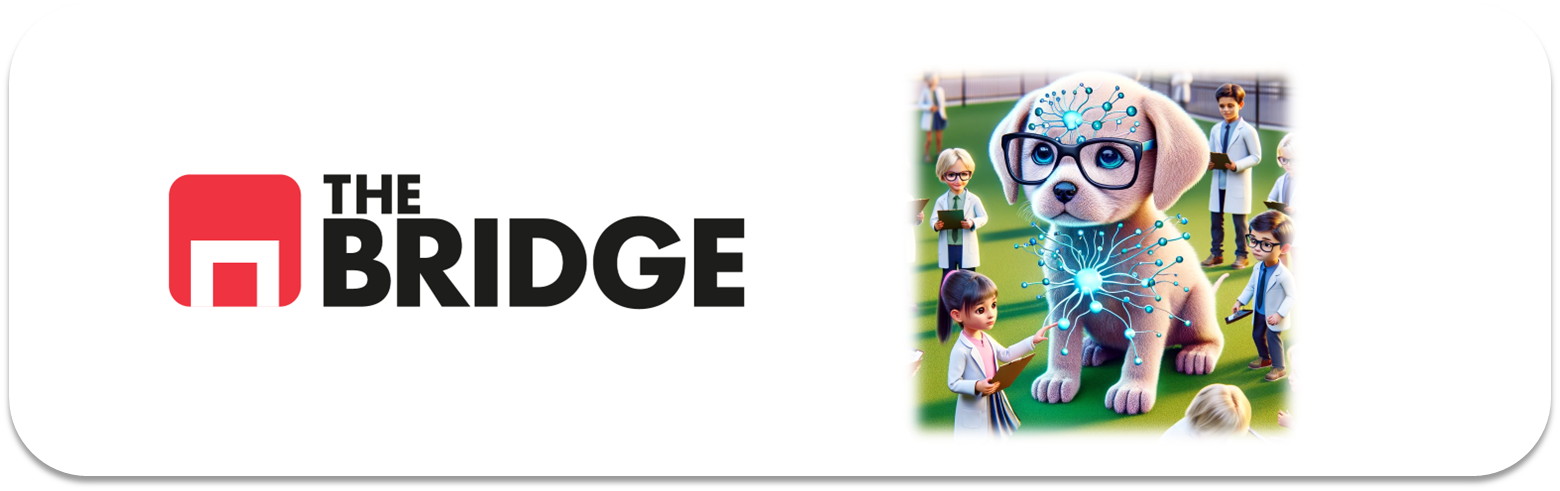

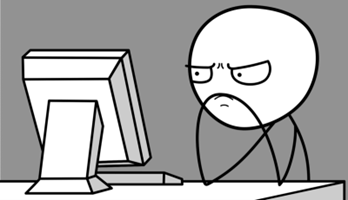

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [2]:
df = pd.read_csv('./air_pollution_new_city.csv', sep='|')

In [3]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [5]:
target = 'pm2.5'

### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [6]:
# Drop unnecessary column
df.drop('No', axis=1, inplace=True)

In [7]:
# rename columns with more descriptive names
df.rename(columns={
    'pm2.5': 'pm2.5_conc',
    'DEWP': 'dew_point',
    'TEMP': 'temperature',
    'PRES': 'pressure',
    'cbwd': 'wind_direction',
    'Iws': 'wind_speed',
    'Is': 'snow_hours',
    'Ir': 'rain_hours'},
    inplace=True)

In [8]:
# redefine target
target = 'pm2.5_conc'

In [9]:
# Create a datetime column from the date columns
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])

# Set new datetime column as index and sort
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# drop old date related columns
df.drop(['year','month','day','hour'], axis=1, inplace=True)

### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

In [10]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
df_train = df['2019':'2022']

<Axes: xlabel='datetime'>

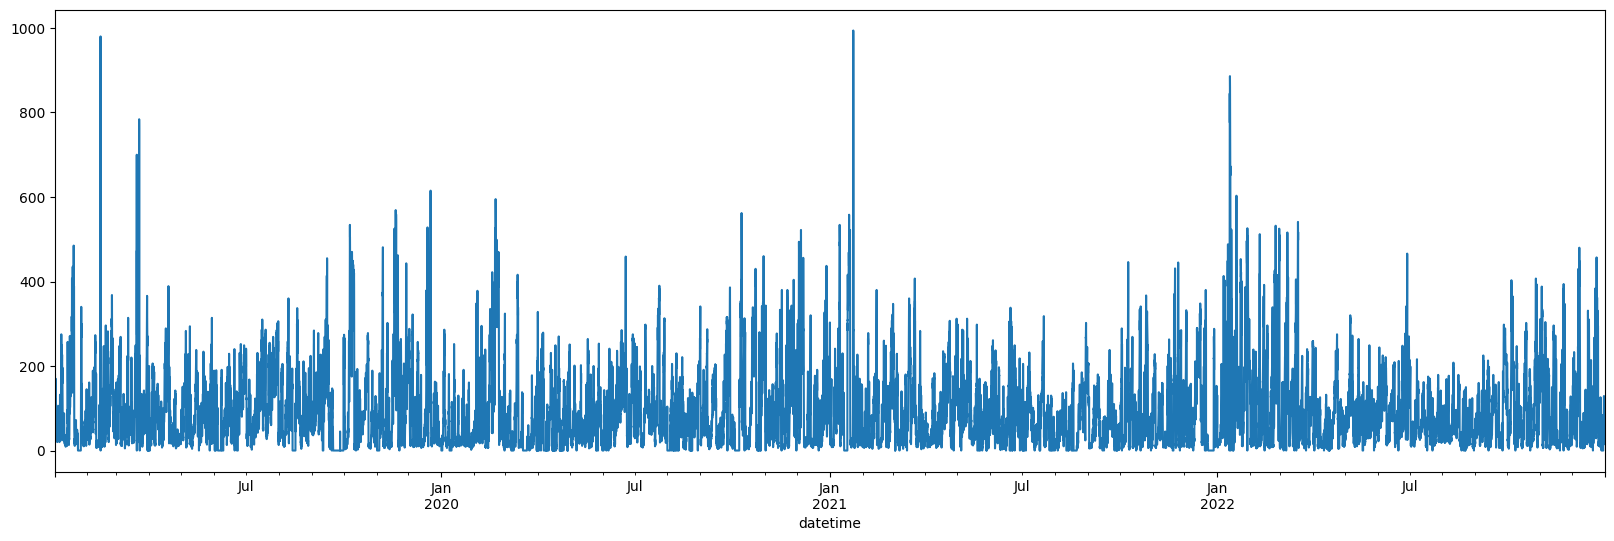

In [12]:
df_train[target].plot(figsize=(20,6))

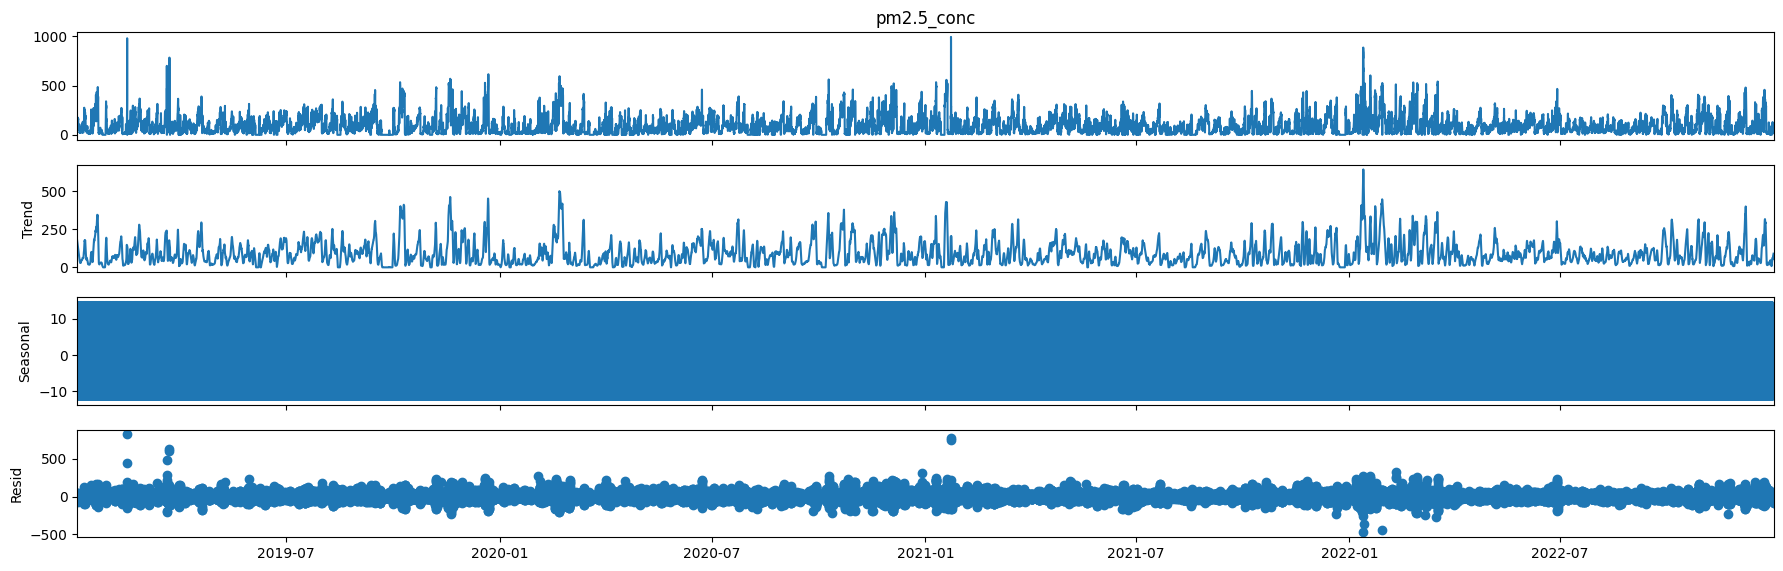

In [13]:
decomp_additive = seasonal_decompose(df_train[target], model='additive', extrapolate_trend='freq')

fig = decomp_additive.plot()
fig.set_size_inches(20,6)
plt.show()

***Trend***  
- some fluctuations with peaks
- mean changing but no real trend

***Seasonality***  
- repetetive pattern between +/- 10

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adf_test = adfuller(df_train[target])

In [16]:
adf_test

(-19.15927906548244,
 0.0,
 52,
 34987,
 {'1%': -3.430536920280192,
  '5%': -2.861622614143799,
  '10%': -2.5668139729124237},
 332359.5242704607)

In [17]:
adf_results = {
    'adfuller stat': adf_test[0],
    'p-value': adf_test[1],
    'used lag': adf_test[2],
    'nobs': adf_test[3],
    'critical vals': adf_test[4]}

In [18]:
adf_results['p-value']

0.0

- according to adfuller p-val we should reject the null hyp and treat the series as stationary
- should use models that assume staionarity --> ARIMA

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

In [19]:
cols_wanted = [col for col in df_train.columns if col != 'wind_direction']

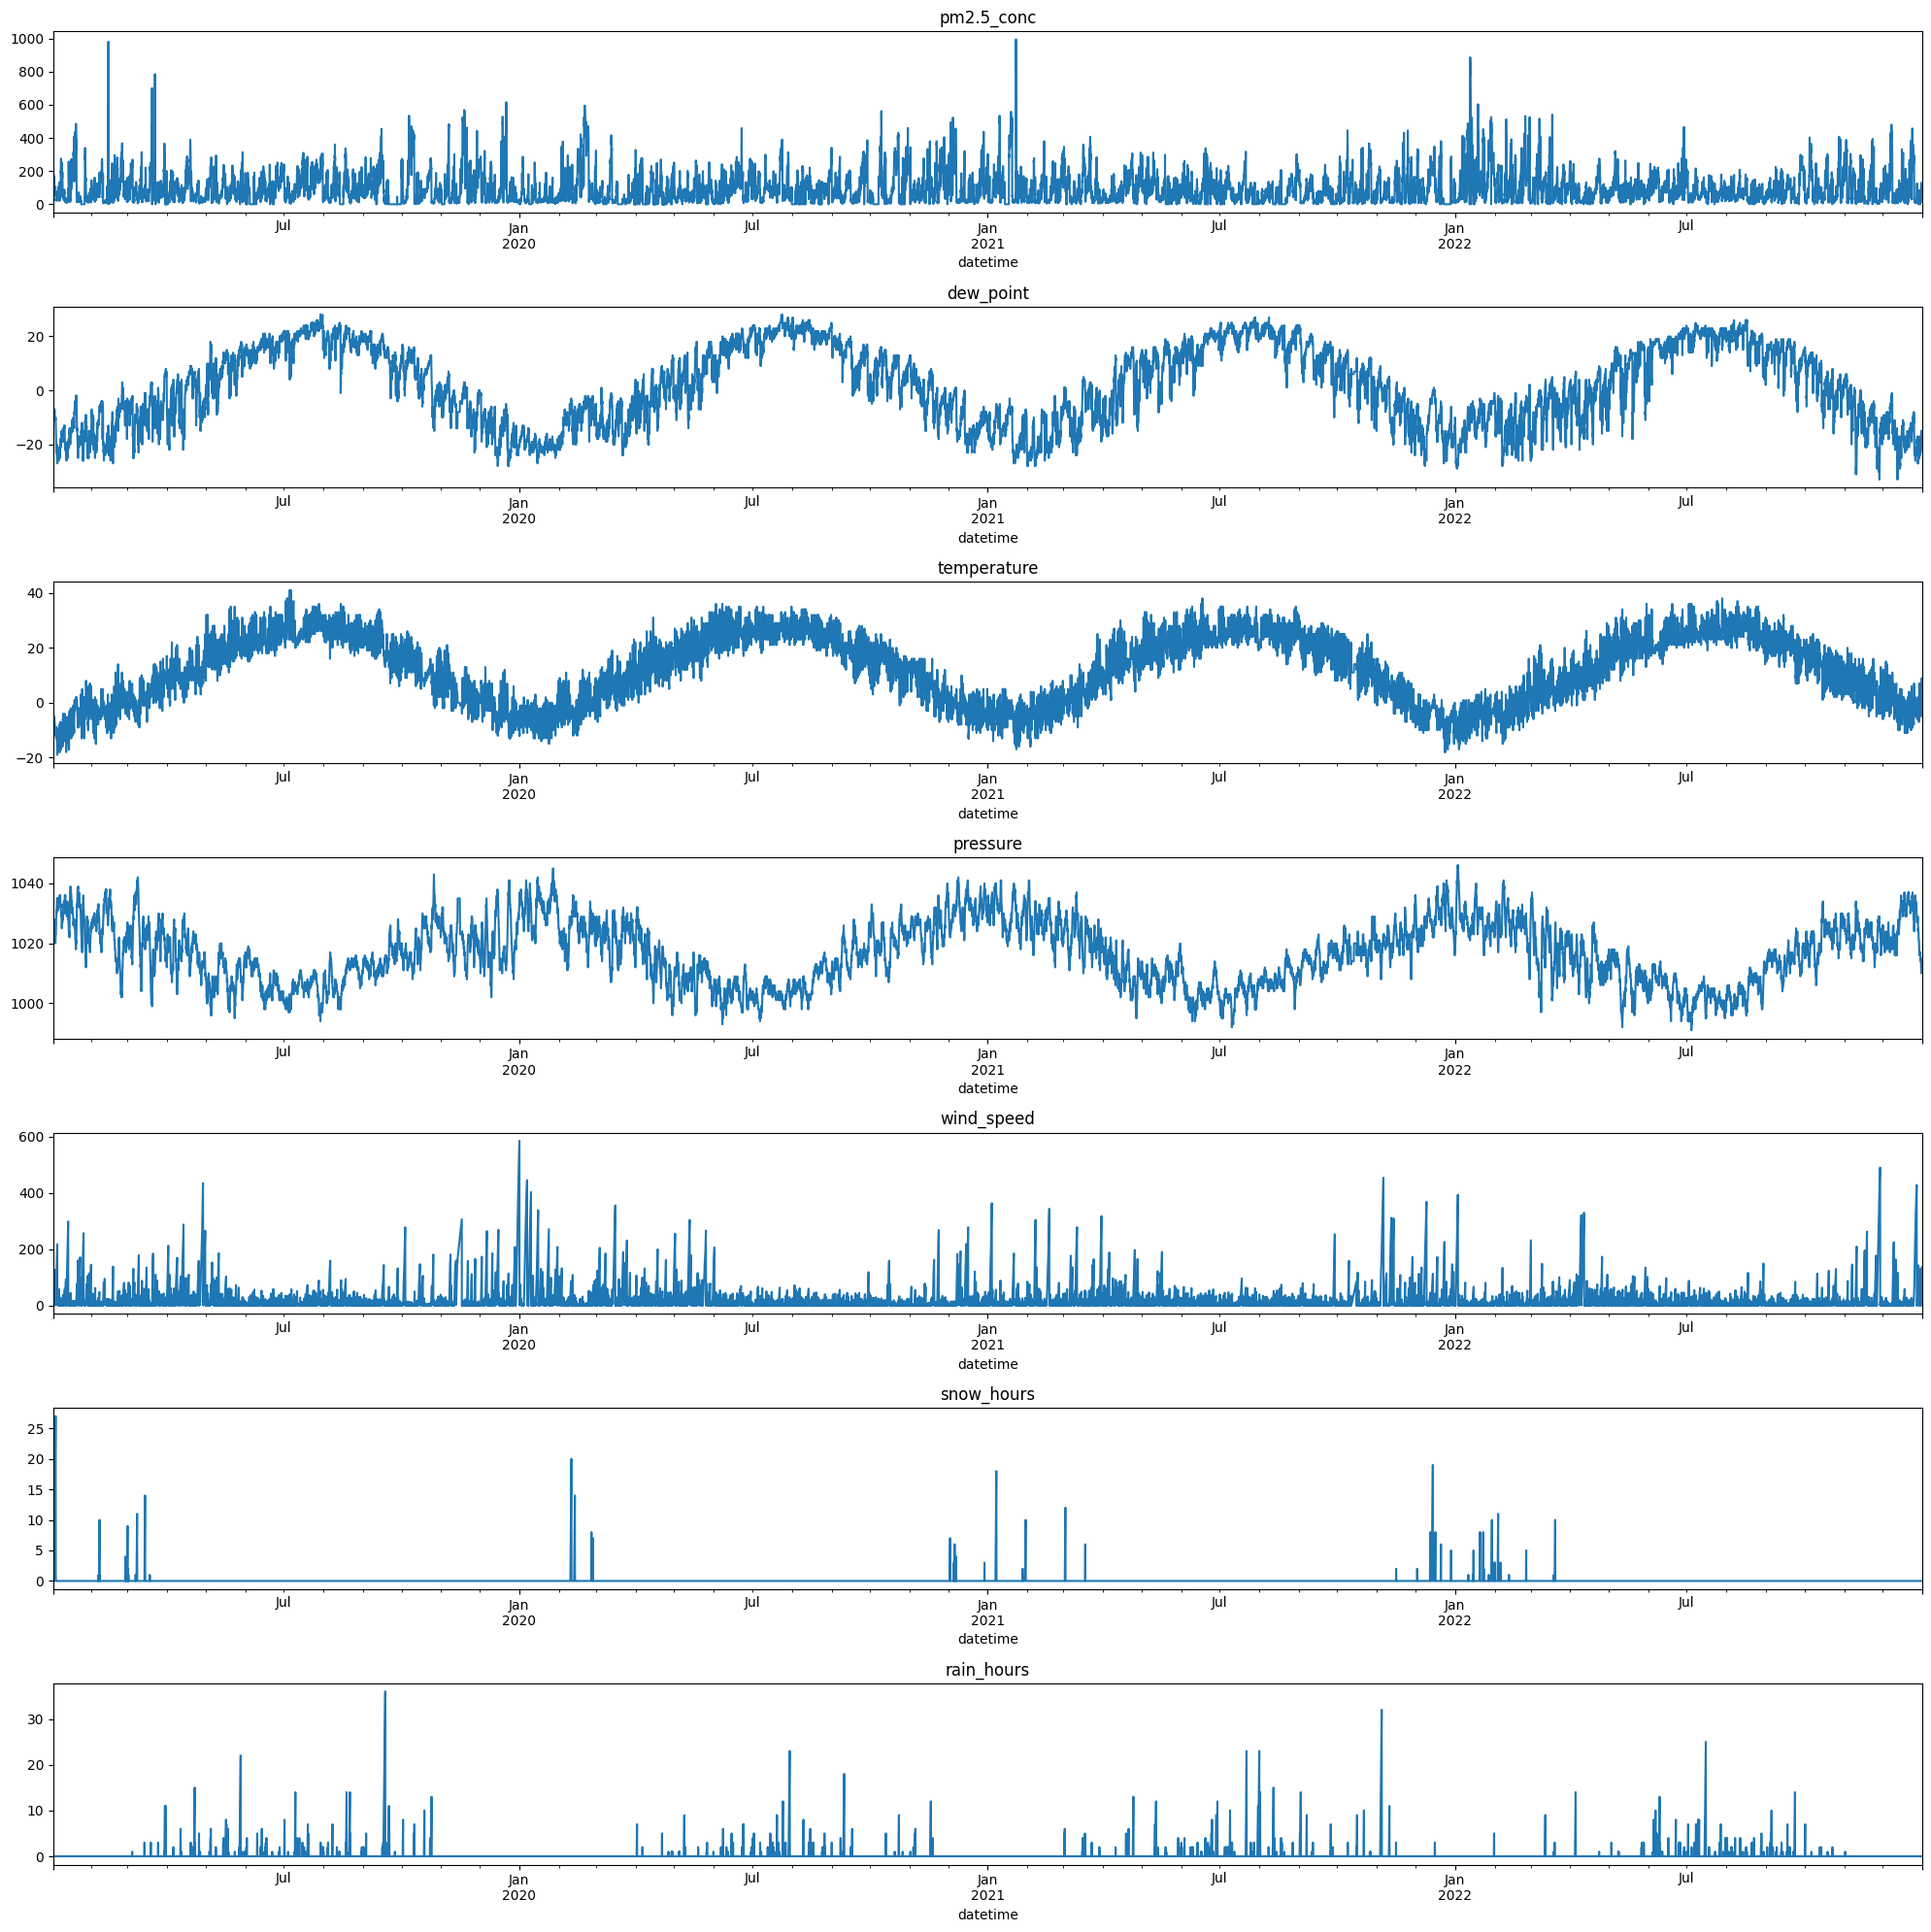

In [20]:
fig, axes = plt.subplots(len(cols_wanted), 1, figsize=(20,20))

for i, col in enumerate(cols_wanted):
    df_train[col].plot(ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [21]:
wind_direction = df_train['wind_direction'].value_counts()
wind_direction

SE    12068
NW    11674
cv     7305
NE     3993
Name: wind_direction, dtype: int64

In [22]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [25]:
wind_encoded = ohe.fit_transform(df[['wind_direction']]).toarray()
oh_col_names = [f'wind_direction_{cat}' for cat in ohe.categories_[0]]

In [26]:
df[oh_col_names] = wind_encoded

In [27]:
df.head()

,pm2.5_conc,dew_point,temperature,pressure,wind_direction,wind_speed,snow_hours,rain_hours,wind_direction_NE,wind_direction_NW,wind_direction_SE,wind_direction_cv
datetime,,,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,0.0,0.0,1.0,0.0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,0.0,0.0,1.0,0.0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,0.0,0.0,1.0,0.0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,0.0,0.0,1.0,0.0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,0.0,0.0,1.0,0.0


In [28]:
df.drop('wind_direction', axis=1, inplace=True)

### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [29]:
df_train = df[:'2023-09'].copy()
df_val = df['2023-09-29':'2023-11-01'].copy()
df_test = df['2023-10-30':'2023-12-01'].copy()

In [30]:
from sklearn.preprocessing import StandardScaler
series_scaler = StandardScaler()
target_scaler = StandardScaler()

In [31]:
cols_wanted.remove(target)

In [33]:
df_train[cols_wanted] = series_scaler.fit_transform(df_train[cols_wanted])
df_val[cols_wanted] = series_scaler.fit_transform(df_val[cols_wanted])
df_test[cols_wanted] = series_scaler.fit_transform(df_test[cols_wanted])

df_train[target] = target_scaler.fit_transform(df_train[[target]])
df_val[target] = target_scaler.fit_transform(df_val[[target]])
df_test[target] = target_scaler.fit_transform(df_test[[target]])

### Ejercicio 7

Prepara los batches siguiendo los pasos que has visto en el workload para multivariante y periodos múltiples

In [36]:
import tensorflow as tf

2024-10-31 12:07:44.980058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
seq_length = 48
prediction_interval = 6

def split_inputs_and_targets(mulvar_series, ahead=prediction_interval, target_col=list(df.columns).index(target)):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=df_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32,
    shuffle=True,
    seed=42,
).map(split_inputs_and_targets)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=df_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32,
).map(split_inputs_and_targets)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=df_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32,
).map(split_inputs_and_targets)

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, df_train.shape[1])),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(prediction_interval)
])

In [47]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience = None):
    
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" el 10% de las épocas
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience= patience, restore_best_weights=True)
    
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=["mae",'root_mean_squared_error'])
    
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    
    val_loss, val_mae, val_rmse = model.evaluate(valid_set)
    return val_loss, target_scaler.inverse_transform([[val_mae, val_rmse]])

In [49]:
val_loss, [[mae, rmse]] = fit_and_evaluate(model, train_ds, val_ds, learning_rate=0.01, epochs=100)

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - loss: 0.2219 - mae: 0.2873 - root_mean_squared_error: 0.4710 - val_loss: 0.2274 - val_mae: 0.2885 - val_root_mean_squared_error: 0.4769
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 0.2268 - mae: 0.2919 - root_mean_squared_error: 0.4761 - val_loss: 0.2327 - val_mae: 0.2907 - val_root_mean_squared_error: 0.4823
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 0.2243 - mae: 0.2897 - root_mean_squared_error: 0.4735 - val_loss: 0.2321 - val_mae: 0.2921 - val_root_mean_squared_error: 0.4818
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.2223 - mae: 0.2889 - root_mean_squared_error: 0.4713 - val_loss: 0.2297 - val_mae: 0.2898 - val_root_mean_squared_error: 0.4793
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.2227 - mae: 0.2895 - root_mean_squared_error: 0.4718 - val_loss: 0.2228 - val_mae: 0.2871 - val_root_mean_squared_error: 0.4720
Epoch 6/100
1299/1299 ━━━

In [54]:
print(f'Val Loss: {val_loss}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

Val Loss: 0.2201746106147766
MAE: 135.53244329838157
RMSE: 155.53912320855744


### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, df_train.shape[1])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(prediction_interval)
])

val_loss, [[mae, rmse]] = fit_and_evaluate(model, train_ds, val_ds, learning_rate=0.01, epochs=100)

Epoch 1/100


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.3482 - mae: 0.3767 - root_mean_squared_error: 0.5854 - val_loss: 0.2495 - val_mae: 0.3021 - val_root_mean_squared_error: 0.4995
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - loss: 0.2409 - mae: 0.2982 - root_mean_squared_error: 0.4908 - val_loss: 0.2408 - val_mae: 0.2933 - val_root_mean_squared_error: 0.4907
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - loss: 0.2316 - mae: 0.2905 - root_mean_squared_error: 0.4811 - val_loss: 0.2325 - val_mae: 0.2881 - val_root_mean_squared_error: 0.4822
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - loss: 0.2269 - mae: 0.2873 - root_mean_squared_error: 0.4763 - val_loss: 0.2340 - val_mae: 0.2861 - val_root_mean_squared_error: 0.4837
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.2238 - mae: 0.2851 - root_mean_squared_error: 0.4730 - val_loss: 0.2260 - val_mae: 0.2846 - val_root_mean_squared_error: 0.4754
Epoch 6/100
1299/1299 ━━━━━━━━━━━━━━━

In [56]:
print(f'Val Loss: {val_loss}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

Val Loss: 0.11092326790094376
MAE: 128.45472085586863
RMSE: 140.8510982473


### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, df_train.shape[1])),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(prediction_interval)
])

val_loss, [[mae, rmse]] = fit_and_evaluate(model, train_ds, val_ds, learning_rate=0.01, epochs=100)

print(f'Val Loss: {val_loss}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - loss: 0.3222 - mae: 0.3545 - root_mean_squared_error: 0.5635 - val_loss: 0.2569 - val_mae: 0.2997 - val_root_mean_squared_error: 0.5068
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - loss: 0.2475 - mae: 0.2981 - root_mean_squared_error: 0.4974 - val_loss: 0.2476 - val_mae: 0.2958 - val_root_mean_squared_error: 0.4976
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - loss: 0.2398 - mae: 0.2939 - root_mean_squared_error: 0.4896 - val_loss: 0.2447 - val_mae: 0.2914 - val_root_mean_squared_error: 0.4946
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 0.2344 - mae: 0.2906 - root_mean_squared_error: 0.4841 - val_loss: 0.2366 - val_mae: 0.2906 - val_root_mean_squared_error: 0.4864
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - loss: 0.2325 - mae: 0.2902 - root_mean_squared_error: 0.4821 - val_loss: 0.2341 - val_mae: 0.2855 - val_root_mean_squared_error: 0.4838
Epoch 6/100
1299/1299 ━━━